In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

# load CFPB public complaint database downloaded from 
# https://www.consumerfinance.gov/data-research/consumer-complaints/
# data was accessed on 4/10/2019
cc = pd.read_csv("CFPB_complaints/Consumer_Complaints_1_10_2020.csv", dtype='str').set_index('Complaint ID')

# missing states replaced with XX
cc['State'][pd.isnull(cc['State'])] = 'XX'

# FIPS codes pulled from https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696
fips = pd.read_csv('CFPB_complaints/State FIPS.csv')

# add DC to FIPS dataframe
fips = fips.append(pd.DataFrame([['District of Columbia', 'DC', 11]], columns=list(fips.columns))).reset_index()

# Map states to FIPS code
fips_dict = fips[['FIPS', 'Postal Code']].set_index('Postal Code').to_dict()['FIPS']
cc['fips'] = cc['State'].replace(fips_dict)

# Create a combined FIPS + Zip code
cc['fips_zip'] = cc['fips'].astype(str).str.zfill(2) + '_' + cc['ZIP code']

# filter for VA
va = cc[cc['State'] == 'VA']

# delete original database
del(cc)

## Upper Districts

In [2]:
# State Legislative Districts by Zip Code Tabulation Areas (ZCTAs)
# https://www.census.gov/geographies/reference-files/time-series/geo/relationship-files.html
# Each state level file was downloaded and placed in the zip_upper directory
zu = pd.concat([pd.read_csv(f, skiprows=1) for f in glob.glob("CFPB_complaints/zip_upper/*.csv")], ignore_index=True)

# create a combined fips + 5 digit string for zip code with leading 0's
zu['fips_zip'] = zu['State'].astype(str).str.zfill(2) + '_' + zu['ZCTA'].astype(str).str.zfill(5)

# create variable with first 3 digits of zip in upper districts dataframe
zu['fips_zip3'] = zu['fips_zip'].str.extract(r'^(\d{2}_\d{3})')

### 5 digits zips

In [3]:
# create smaller frame with only with complaints where the zip code is 5 digits and not missing
v5 = va[ va['fips_zip'].notnull() & va['fips_zip'].str.match(r'^\d{2}_\d{5}') ]
v5.reset_index(inplace=True)

# keep only Complaint ID and ZIP code to save memory
v5 = v5[['Complaint ID', 'fips_zip']]

# merge complaint data with upper districts data
dfu5 = v5.merge(right=zu, how='left', left_on='fips_zip', right_on='fips_zip')

# aggregate upper districts by Complaint ID
gbu5 = dfu5.groupby('Complaint ID')
upper5 = gbu5['StateLegislativeDistrictsUpper'].unique()

# add a column with the results to the 5 digit zip dataframe
v5 = v5.set_index('Complaint ID')
v5['StateLegislativeDistrictsUpper'] = upper5

### 3 digits zips

In [4]:
# extract first 3 digits only if the zip code is in the form dddXX
# everything else is missing
va['fips_zip3'] = va['fips_zip'].str.extract(r'^(\d{2}_\d{3})XX')

v3 = va[va['fips_zip3'].notnull()]
v3.reset_index(inplace=True)

v3 = v3[['Complaint ID', 'fips_zip3']]

# merge comlaint IDs with upper districts
dfu3 = v3.merge(right=zu, how='left', left_on='fips_zip3', right_on='fips_zip3')

# aggregate upper districts by Complaint ID
gbu3 = dfu3.groupby('Complaint ID')
upper3 = gbu3['StateLegislativeDistrictsUpper'].unique()

# add a column with the results to the 3 digit zip dataframe
v3.set_index('Complaint ID', inplace=True)
v3['StateLegislativeDistrictsUpper'] = upper3

# combine both upper district dataframes
vf = pd.concat([v5['StateLegislativeDistrictsUpper'], 
               v3['StateLegislativeDistrictsUpper']])

# assign upper district to a new column in the original database
va['StateLegislativeDistrictsUpper'] = vf

## Lower Districts

In [5]:
# load zip code to legislative district mapping datasets
zl = pd.concat([pd.read_csv(f, skiprows=1) for f in glob.glob("CFPB_complaints/zip_lower/*.csv")], ignore_index=True)

# create a 5 digit string for zip code with leading 0's
zl['fips_zip'] = zl['State'].astype(str).str.zfill(2) + '_' + zl['ZCTA'].astype(str).str.zfill(5)

### 5 digit zips

In [6]:
### match 5 digit zip codes
v5 = v5.reset_index()
v5 = v5[['Complaint ID', 'fips_zip']]

# merge complaint data with upper districts data
dfl5 = v5.merge(right=zl, how='left', left_on='fips_zip', right_on='fips_zip')

# aggregate lower districts by Complaint ID
gbl5 = dfl5.groupby('Complaint ID')
lower5 = gbl5['StateLegislativeDistrictsLower'].unique()

# add a column with the results to the 5 digit zip dataframe
v5 = v5.set_index('Complaint ID')
v5['StateLegislativeDistrictsLower'] = lower5

### 3 digit zips

In [7]:
### match 3 digit zip codes
v3 = v3.reset_index()
v3 = v3[['Complaint ID', 'fips_zip3']]

# create variable with first 3 digits of zip in upper districts dataframe
zl['fips_zip3'] = zl['fips_zip'].str.extract(r'^(\d{2}_\d{3})')

# merge comlaint IDs with upper districts
dfl3 = v3.merge(right=zl, how='left', left_on='fips_zip3', right_on='fips_zip3')

# aggregate lower districts by Complaint ID
gb = dfl3.groupby('Complaint ID')
lower3 = gb['StateLegislativeDistrictsLower'].unique()

# add a column with the results to the 3 digit zip dataframe
v3 = v3.set_index('Complaint ID')
v3['StateLegislativeDistrictsLower'] = lower3

# combine both upper district dataframes
vf = pd.concat([v5['StateLegislativeDistrictsLower'], 
               v3['StateLegislativeDistrictsLower']])

# assign upper district to a new column in the original database
va['StateLegislativeDistrictsLower'] = vf

## Counties

In [8]:
# read in county data
zc = pd.read_csv("CFPB_complaints/zip_county/zcta_county_rel_10.csv", usecols=['ZCTA5', 'STATE', 'COUNTY'])

# create 5 digit zip codes with leading 0's
# zc['zip'] = zc['ZCTA5'].astype(str).str.zfill(5)
zc['fips_zip'] = zc['STATE'].astype(str).str.zfill(2) + '_' + zc['ZCTA5'].astype(str).str.zfill(5)

In [9]:
v5 = v5.reset_index()
v5 = v5[['Complaint ID', 'fips_zip']]

# merge on 5 digit zip codes
dfc5 = v5.merge(right=zc, how='left', left_on='fips_zip', right_on='fips_zip')

In [10]:
# aggregate counties by Complaint ID
gb = dfc5.groupby('Complaint ID')
counties = gb['COUNTY'].unique()

# add a column with the results to the 5 digit zip dataframe
v5 = v5.set_index('Complaint ID')
v5['County'] = counties

In [11]:
# create variable with first 3 digits of zip in the right dataframe
zc['fips_zip3'] = zc['fips_zip'].str.extract(r'^(\d{2}_\d{3})')

In [12]:
v3 = v3.reset_index()
v3 = v3[['Complaint ID', 'fips_zip3']]

# merge comlaint IDs with upper districts
dfc3 = v3.merge(right=zc, how='left', left_on='fips_zip3', right_on='fips_zip3')

# aggregate upper districts by Complaint ID
gb = dfc3.groupby('Complaint ID')
result = gb['COUNTY'].unique()

# add a column with the results to the 3 digit zip dataframe
v3 = v3.set_index('Complaint ID')
v3['County'] = result

# combine both upper district dataframes
vf = pd.concat([v5['County'], 
               v3['County']])

# assign upper district to a new column in the original database
va['County'] = vf

# New Data

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib notebook

In [14]:
data = gpd.read_file(r'VA Redistricting/data/final_remedial_plan/final_remedial_plan.shp')

In [15]:
zcta =  gpd.read_file(r'VA Redistricting/data/tl_2019_us_zcta510/tl_2019_us_zcta510.shp')

In [16]:
va_zips = zcta[zcta['geometry'].intersects(data['geometry'].unary_union)].copy()

In [17]:
def get_district_list2(x):
    intersect = data.loc[:,'geometry'].intersects(x)
    touch = data.loc[:,'geometry'].touches(x)
    return list(data.loc[ (intersect & ~touch), 'District_N' ])

In [18]:
va_zips['district_list'] = va_zips['geometry'].apply(get_district_list2)

In [19]:
ax = va_zips.plot(alpha=0.5)
zip_22015.plot(ax=ax, color='red')

<IPython.core.display.Javascript object>

NameError: name 'zip_22015' is not defined

<IPython.core.display.Javascript object>


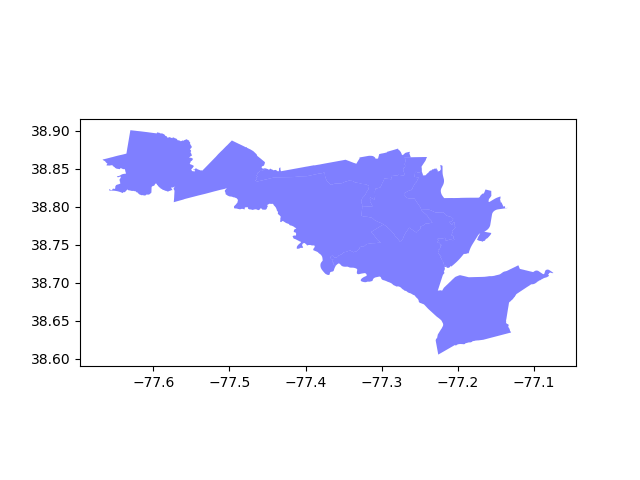

NameError: name 'zip_22015' is not defined

In [20]:
ax = data[data['District_1']==37].plot(color='blue', alpha =0.5)
data[data['District_1']==39].plot(ax=ax, color='blue', alpha =0.5)
data[data['District_1']==40].plot(ax=ax, color='blue', alpha =0.5)
data[data['District_1']==41].plot(ax=ax, color='blue', alpha =0.5)
data[data['District_1']==42].plot(ax=ax, color='blue', alpha =0.5)

zip_22015.plot(ax=ax, color='red', alpha = 1)

In [21]:
ax = data[data['District_1']==37].plot(color='blue', alpha =0.5)
data[data['District_1']==39].plot(ax=ax, color='blue', alpha =0.5)
data[data['District_1']==40].plot(ax=ax, color='blue', alpha =0.5)
data[data['District_1']==41].plot(ax=ax, color='green', alpha =0.5)
data[data['District_1']==42].plot(ax=ax, color='blue', alpha =0.5)

zip_22015.plot(ax=ax, color='red', alpha = 1)

<IPython.core.display.Javascript object>

NameError: name 'zip_22015' is not defined

### HERE

In [22]:
va.reset_index(inplace=True)

In [23]:
va_new = va.merge(va_zips[['ZCTA5CE10', 'district_list']], left_on='ZIP code', right_on='ZCTA5CE10', how='left')

In [24]:
va_new.head()

,Complaint ID,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,...,Timely response?,Consumer disputed?,fips,fips_zip,fips_zip3,StateLegislativeDistrictsUpper,StateLegislativeDistrictsLower,County,ZCTA5CE10,district_list
0,2831821,03/03/2018,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,On XX/XX/18 an item showed up on my credit rep...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",VA,...,Yes,NaN,51,51_245XX,51_245,"[22, 23, 15, 20, 25, 19]","[22, 23, 59, 60, 24, 19, 14, 16, 61, 58, 65]","[31.0, 680.0, 19.0, 11.0, 83.0, 9.0, 125.0, 29...",NaN,NaN
1,3024649,09/20/2018,Checking or savings account,Other banking product or service,Problem with a lender or other company chargin...,Can't stop withdrawals from your account,NaN,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,VA,...,Yes,NaN,51,51_226XX,51_226,"[27, 26]","[29, 33, 10, 15, 18]","[69.0, 840.0, 187.0, 43.0, 157.0, 61.0, 171.0,...",NaN,NaN
2,347231,03/08/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",VA,...,Yes,Yes,51,51_201XX,51_201,"[13, 27, 24, 26, 29, 28, 39, 36, 34, 37, 33, 3...","[10, 33, 87, 18, 13, 40, 50, 51, 31, 37, 67, 4...","[107.0, 47.0, 61.0, 157.0, 153.0, 683.0, 685.0...",NaN,NaN
3,1609557,10/15/2015,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",NaN,I have been trying to get a loan Modification ...,NaN,Ocwen Financial Corporation,VA,...,Yes,No,51,51_234XX,51_234,"[6, 3, 18, 14, 1, 8, 7]","[100, 64, 76, 77, 80, 81, 82, 21, 83, 84, 85, 90]","[1.0, 131.0, 93.0, 800.0, 810.0]",NaN,NaN
4,467255,07/26/2013,Consumer Loan,Vehicle loan,Problems when you are unable to pay,NaN,NaN,NaN,WELLS FARGO & COMPANY,VA,...,Yes,No,51,51_23235,NaN,"[10, 11]","[27, 68, 69]","[41.0, 760.0]",23235,"[27, 66, 68, 69, 73]"


In [25]:
# get first 3 digits of ZCTA5CE10
va_zips['zip3'] = va_zips['ZCTA5CE10'].str.extract(r'(\d{3})\d{2}')

In [26]:
gbzip3 = va_zips.groupby('zip3')['district_list']

In [27]:
va_zip3 = gbzip3.sum().apply(lambda x: np.unique(x))

In [28]:
va_new['zip3'] = va_new['ZIP code'].str.extract(r'^(\d{3})XX')

In [29]:
va_new.head()

,Complaint ID,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,...,Consumer disputed?,fips,fips_zip,fips_zip3,StateLegislativeDistrictsUpper,StateLegislativeDistrictsLower,County,ZCTA5CE10,district_list,zip3
0,2831821,03/03/2018,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,On XX/XX/18 an item showed up on my credit rep...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",VA,...,NaN,51,51_245XX,51_245,"[22, 23, 15, 20, 25, 19]","[22, 23, 59, 60, 24, 19, 14, 16, 61, 58, 65]","[31.0, 680.0, 19.0, 11.0, 83.0, 9.0, 125.0, 29...",NaN,NaN,245
1,3024649,09/20/2018,Checking or savings account,Other banking product or service,Problem with a lender or other company chargin...,Can't stop withdrawals from your account,NaN,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,VA,...,NaN,51,51_226XX,51_226,"[27, 26]","[29, 33, 10, 15, 18]","[69.0, 840.0, 187.0, 43.0, 157.0, 61.0, 171.0,...",NaN,NaN,226
2,347231,03/08/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",VA,...,Yes,51,51_201XX,51_201,"[13, 27, 24, 26, 29, 28, 39, 36, 34, 37, 33, 3...","[10, 33, 87, 18, 13, 40, 50, 51, 31, 37, 67, 4...","[107.0, 47.0, 61.0, 157.0, 153.0, 683.0, 685.0...",NaN,NaN,201
3,1609557,10/15/2015,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",NaN,I have been trying to get a loan Modification ...,NaN,Ocwen Financial Corporation,VA,...,No,51,51_234XX,51_234,"[6, 3, 18, 14, 1, 8, 7]","[100, 64, 76, 77, 80, 81, 82, 21, 83, 84, 85, 90]","[1.0, 131.0, 93.0, 800.0, 810.0]",NaN,NaN,234
4,467255,07/26/2013,Consumer Loan,Vehicle loan,Problems when you are unable to pay,NaN,NaN,NaN,WELLS FARGO & COMPANY,VA,...,No,51,51_23235,NaN,"[10, 11]","[27, 68, 69]","[41.0, 760.0]",23235,"[27, 66, 68, 69, 73]",NaN


In [30]:
va_new3 = va_new[va_new['zip3'].notnull()]

In [31]:
va3_merged = va_new3.merge(va_zip3, left_on='zip3', right_on='zip3', how='left')

In [32]:
va3_merged = va3_merged.drop(columns=['district_list_x'])

In [33]:
va3_merged = va3_merged.rename(columns={'district_list_y': 'district_list'})

In [34]:
va_new5 = va_new[va_new['zip3'].isnull()]

In [35]:
va_new5.set_index('Complaint ID', inplace=True)

In [36]:
va3_merged.set_index('Complaint ID', inplace=True)

In [37]:
col_list = va_new5.columns.to_list()

In [38]:
va3_merged = va3_merged[col_list]

In [39]:
vf = pd.concat([va_new5, va3_merged])

In [40]:
vf.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Consumer disputed?,fips,fips_zip,fips_zip3,StateLegislativeDistrictsUpper,StateLegislativeDistrictsLower,County,ZCTA5CE10,district_list,zip3
Complaint ID,,,,,,,,,,,,,,,,,,,,,
467255,07/26/2013,Consumer Loan,Vehicle loan,Problems when you are unable to pay,NaN,NaN,NaN,WELLS FARGO & COMPANY,VA,23235,...,No,51,51_23235,NaN,"[10, 11]","[27, 68, 69]","[41.0, 760.0]",23235,"[27, 66, 68, 69, 73]",NaN
1587491,09/30/2015,Bank account or service,Checking account,"Making/receiving payments, sending money",NaN,A payee to whom I wrote a check erroneously ca...,Company chooses not to provide a public response,"SUNTRUST BANKS, INC.",VA,NaN,...,No,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1053639,10/01/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"CITIBANK, N.A.",VA,22903,...,No,51,51_22903,NaN,[25],"[25, 57, 59]","[3.0, 540.0]",22903,"[25, 57, 58, 59]",NaN
588582,11/06/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,NaN,Ditech Financial LLC,VA,23185,...,No,51,51_23185,NaN,"[1, 3, 9]","[74, 93, 96]","[36.0, 95.0, 199.0, 830.0]",23185,"[64, 70, 93, 94, 96]",NaN
1731512,01/07/2016,Credit reporting,NaN,Incorrect information on credit report,Public record,NaN,NaN,"The CBE Group, Inc.",VA,22152,...,No,51,51_22152,NaN,"[35, 37, 39]","[41, 42]",[59.0],22152,"[39, 41, 42]",NaN


In [41]:
vf.tail()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Consumer disputed?,fips,fips_zip,fips_zip3,StateLegislativeDistrictsUpper,StateLegislativeDistrictsLower,County,ZCTA5CE10,district_list,zip3
Complaint ID,,,,,,,,,,,,,,,,,,,,,
3489222,01/08/2020,Debt collection,Medical debt,Took or threatened to take negative or legal a...,Threatened to sue you for very old debt,NaN,NaN,Suburban Credit Corporation,VA,221XX,...,NaN,51,51_221XX,51_221,"[31, 32, 34, 36, 28, 35, 39, 37, 29]","[34, 48, 53, 35, 36, 67, 52, 2, 39, 41, 42, 43...","[13.0, 59.0, 153.0, 179.0]",NaN,"[2, 28, 31, 34, 35, 36, 37, 39, 40, 41, 42, 43...",221
3434234,11/10/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,NaN,NaN,"EQUIFAX, INC.",VA,201XX,...,NaN,51,51_201XX,51_201,"[13, 27, 24, 26, 29, 28, 39, 36, 34, 37, 33, 3...","[10, 33, 87, 18, 13, 40, 50, 51, 31, 37, 67, 4...","[107.0, 47.0, 61.0, 157.0, 153.0, 683.0, 685.0...",NaN,"[10, 13, 18, 31, 32, 33, 34, 36, 37, 40, 42, 5...",201
3434351,11/10/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Unable to get your credit report or credit score,Problem getting your free annual credit report,NaN,NaN,"EQUIFAX, INC.",VA,221XX,...,NaN,51,51_221XX,51_221,"[31, 32, 34, 36, 28, 35, 39, 37, 29]","[34, 48, 53, 35, 36, 67, 52, 2, 39, 41, 42, 43...","[13.0, 59.0, 153.0, 179.0]",NaN,"[2, 28, 31, 34, 35, 36, 37, 39, 40, 41, 42, 43...",221
3480602,12/30/2019,Credit card or prepaid card,General-purpose credit card or charge card,"Advertising and marketing, including promotion...",Confusing or misleading advertising about the ...,Advertised an XXXX XXXX card on the XXXX app. ...,Company has responded to the consumer and the ...,BARCLAYS BANK DELAWARE,VA,232XX,...,NaN,51,51_232XX,51_232,"[9, 10, 16, 12, 22, 11]","[69, 71, 68, 74, 70, 27, 73, 72, 62, 56, 66]","[760.0, 87.0, 41.0, 36.0, 75.0]",NaN,"[27, 55, 56, 62, 65, 66, 68, 69, 70, 71, 72, 7...",232
3434375,11/10/2019,Credit card or prepaid card,General-purpose credit card or charge card,Fees or interest,Problem with fees,NaN,NaN,BBVA FINANCIAL CORPORATION,VA,222XX,...,NaN,51,51_222XX,51_222,"[31, 32, 30, 35]","[47, 48, 45, 49, 53, 46]","[13.0, 610.0, 510.0, 59.0]",NaN,"[34, 45, 46, 47, 48, 49, 53]",222


In [42]:
vf.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'fips', 'fips_zip',
       'fips_zip3', 'StateLegislativeDistrictsUpper',
       'StateLegislativeDistrictsLower', 'County', 'ZCTA5CE10',
       'district_list', 'zip3'],
      dtype='object')

In [43]:
vf = vf.drop(columns=['fips', 'fips_zip', 'fips_zip3', 'ZCTA5CE10', 'zip3'])

In [44]:
vf.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,StateLegislativeDistrictsUpper,StateLegislativeDistrictsLower,County,district_list
Complaint ID,,,,,,,,,,,,,,,,,,,,,
467255,07/26/2013,Consumer Loan,Vehicle loan,Problems when you are unable to pay,NaN,NaN,NaN,WELLS FARGO & COMPANY,VA,23235,...,NaN,Web,07/29/2013,Closed with explanation,Yes,No,"[10, 11]","[27, 68, 69]","[41.0, 760.0]","[27, 66, 68, 69, 73]"
1587491,09/30/2015,Bank account or service,Checking account,"Making/receiving payments, sending money",NaN,A payee to whom I wrote a check erroneously ca...,Company chooses not to provide a public response,"SUNTRUST BANKS, INC.",VA,NaN,...,Consent provided,Web,09/30/2015,Closed with monetary relief,Yes,No,NaN,NaN,NaN,NaN
1053639,10/01/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"CITIBANK, N.A.",VA,22903,...,NaN,Referral,10/07/2014,Closed with explanation,Yes,No,[25],"[25, 57, 59]","[3.0, 540.0]","[25, 57, 58, 59]"
588582,11/06/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,NaN,Ditech Financial LLC,VA,23185,...,NaN,Web,11/06/2013,Closed with explanation,Yes,No,"[1, 3, 9]","[74, 93, 96]","[36.0, 95.0, 199.0, 830.0]","[64, 70, 93, 94, 96]"
1731512,01/07/2016,Credit reporting,NaN,Incorrect information on credit report,Public record,NaN,NaN,"The CBE Group, Inc.",VA,22152,...,Consent not provided,Web,01/12/2016,Closed with explanation,Yes,No,"[35, 37, 39]","[41, 42]",[59.0],"[39, 41, 42]"


In [45]:
vf.to_csv('CFPB_VA_Geo_Update.csv')